# Causal discovery on CauseMe.net

Causal discovery concerns the task of estimating causal dependencies from data given a set of assumptions. For an introduction see this paper:

Inferring causation from time series in Earth system sciences. J. Runge, S. Bathiany, E. Bollt, G. Camps-Valls, D. Coumou, E. Deyle, C. Glymour, M. Kretschmer, M.D. Mahecha, J. Munoz-Mari, E.H. van Ness, J. Peters, R. Quax, M. Reichstein, M. Scheffer, B. Schölkopf, P. Spirtes, G. Sugihara, J. Sun, K. Zhang, J. Zscheischler. Nature Communications (2019).
https://www.nature.com/articles/s41467-019-10105-3/

This tutorial illustrates a simple causal discovery method applied to a multivariate time series. In the example scripts on CauseMe (in different programming languages) you can find the same method and how to apply it on the datasets provided on CauseMe.

In [1]:
# Imports
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, average_precision_score

from causeme_my_method import my_method

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     

In [2]:
# Fix random seed
np.random.seed(42)

# Number of variables N
N = 4

# Time series length T
T = 150

# Initialize Gaussian noise
data = np.random.randn(T, N) 

# Consider a time series coming from the following data generating process
for t in range(5, T):
    data[t,0] = 0.7*data[t-1,0] - 0.5*data[t-4,1] + np.random.randn()
    data[t,1] = 0.8*data[t-1,1] + 0.4*data[t-1,2] + np.random.randn()
    data[t,2] = 0.5*data[t-1,2] + np.random.randn()
    data[t,3] = 0.4*data[t-1,3] + 0.2*data[t-2,2] + np.random.randn()

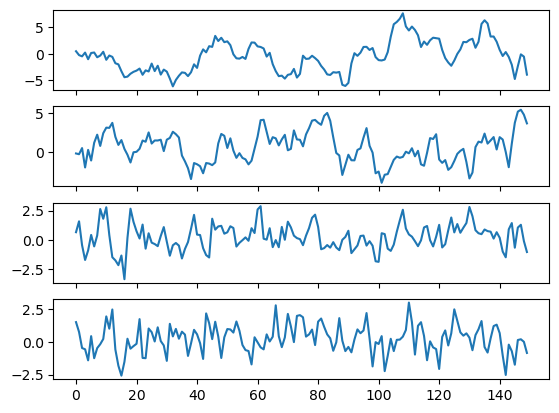

In [3]:
# Plot the data
fig, axes = plt.subplots(N, sharex=True)
for j in range(N):
    axes[j].plot(data[:,j])
plt.show()

Our goal is to reconstruct the causal drivers (or parents) among each of the four variables, which are simply the variables appearing on the right-hand side of the data generating process. On CauseMe, we do not evaluate whether auto-links, that is, past lags of the same variable, are correctly estimated. The causal (process) graph for this data generating process is this:

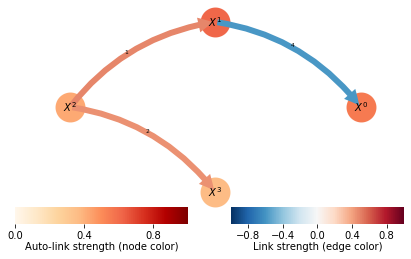

## Spurious correlations

You can see the common driver pattern $X^1 \leftarrow X^2 \rightarrow X^3$ which gives rise to *spurious correlations*: $X^1$ and $X^3$ are correlated even though neither appears as a parent in the data generating process. There is also an indirect causal path $X^2 \rightarrow X^1 \rightarrow X^0$ leading to $X^2$ and $X^0$ being correlated. The latter can be seen as an indirect causation, but on CauseMe we are interested in direct causal links.

In [4]:
# Lag-zero correlations
correlations = np.corrcoef(data, rowvar=0)
print(correlations)

[[ 1.         -0.13509365  0.2584564   0.0367854 ]
 [-0.13509365  1.          0.01181956  0.11877403]
 [ 0.2584564   0.01181956  1.          0.10802894]
 [ 0.0367854   0.11877403  0.10802894  1.        ]]


Essentially all variables are correlated with each other. If we would take into account further time lags, the correlations would be even more apparent.

## A simple causal discovery method
Now consider a vector-autoregressive model estimator as a very simple causal discovery method appropriate for time series with lagged causal links. ``varmodel`` is implemented as ``my_method`` in the provided module based on the python ``statsmodels`` package.

The free parameter of this method is ``maxlags`` which sets the maximum past time lag to take into account. In the model experiment descriptions on CauseMe you may find hints on what maximal time lag to expect. Here ``maxlags = 5``. The output of ``my_method`` are three matrices: a score matrix, a matrix of p-values, and a matrix of time lags. The ``score_matrix`` contains the (absolute) values of estimated coefficients between each pair of variables at the time lag with smallest p-value (multiplied by ``maxlags`` to account for multiple testing, see method code). The ``p_matrix`` contains the corresponding p-values and the ``lag_matrix`` the time lags.

In [5]:
# Run example method
score_matrix, p_matrix, lag_matrix = my_method(data, maxlags=5)

D:\apps\anaconda\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


In [6]:
print("Score matrix")
print(score_matrix.round(2))
print("p-value matrix")
print(p_matrix.round(5))
print("Time lag matrix")
print(lag_matrix)
print("Significant links at 5%")
print(p_matrix <= 0.05)

Score matrix
[[0.71 0.13 0.24 0.52]
 [0.27 0.91 0.28 0.15]
 [0.07 0.16 0.49 0.36]
 [0.06 0.11 0.21 0.36]]
p-value matrix
[[0.0000e+00 1.0000e+00 9.6118e-01 4.4833e-01]
 [1.1000e-04 0.0000e+00 4.4072e-01 1.0000e+00]
 [3.1322e-01 9.1010e-02 0.0000e+00 3.0600e-03]
 [1.7478e-01 2.2025e-01 2.9900e-02 2.5000e-04]]
Time lag matrix
[[1 5 5 2]
 [4 1 4 5]
 [2 2 1 2]
 [4 4 5 1]]
Significant links at 5%
[[ True False False False]
 [ True  True False False]
 [False False  True  True]
 [False False  True  True]]


## Evaluation metrics

The ground truth matrix for this process and the true lag matrix are

In [7]:
truth_matrix = np.array(
                    [[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 1],
                     [0, 0, 0, 0]])
truth_lag_matrix= np.array(
                    [[0, 0, 0, 0],
                     [4, 0, 0, 0],
                     [0, 1, 0, 2],
                     [0, 0, 0, 0]])

CauseMe features different evaluation metrics as described on the platform. For example, the Area Under the Receiver Operating Characteristic Curve (AUC) is based on the score matrix, while the False Positive Rate (FPR) and True Positive Rate (TPR) are based on the p-value matrices thresholded at a 5% significance level. While the score_matrix is required, the p_matrix and lag_matrix are optional. Here we get the following results:

In [11]:
# AUC
# Auto-links are ignored
select_off_diagonal = (np.identity(N) == 0)
auc = roc_auc_score(y_true=truth_matrix[select_off_diagonal], y_score=score_matrix[select_off_diagonal])
print(truth_matrix[select_off_diagonal])
print(score_matrix[select_off_diagonal])
print("AUC = %.2f" % (auc))

# FPR and TPR
alpha_level = 0.05
tn, fp, fn, tp = confusion_matrix(y_true=truth_matrix[select_off_diagonal],
                                  y_pred=(p_matrix <= alpha_level)[select_off_diagonal]).ravel()
fpr = fp / float(fp + tn)
tpr = tp / float(tp + fn)
print("FPR = %.2f" % (fpr))
print("TPR = %.2f" % (tpr))

[0 0 0 1 0 0 0 1 1 0 0 0]
[0.12638974 0.23518057 0.5205796  0.26602364 0.2754392  0.14621656
 0.06812698 0.15556985 0.3647875  0.06423646 0.11041901 0.21318065]
AUC = 0.74
FPR = 0.11
TPR = 0.67


The higher the AUC, the better. On the other hand, the FPR should be below 5% here and only then can a high TPR be correctly compared with other methods.

Each experiment on CauseMe, e.g., ``linear-VAR_N-5_T-300``, consists not only of one multivariate time series as analyzed here, but of a few hundred such datasets, each with different ground truth but of the same class of data generating process. Then the metrics are evaluated on the *concatenated* ground truth matrices. This allows for much more robust estimates of the evaluation metrics. For example, in our example we would expect the FPR to be around 0.05 for a well-calibrated test.

This was an easy example, on CauseMe you find many more challenging datasets featuring not just time delays and autocorrelation, but also nonlinearity, chaotic dynamics, extreme events, time-aggregation, and many more. 

_Please contact us if you want to contribute further datasets with known ground truth!_

Now start downloading datasets and apply your own methods! Visit the Methods page to checkout benchmark methods provided by CauseMe and further methods uploaded by users.

Don't just label me. Cause Me!